In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from typing import *
from sensetools.plots import feature_labeller

In [3]:
from scipy.stats import spearmanr
from collections import defaultdict

In [4]:
protein = '1fme'
lag = 41
# md_t2 = {'1fme': 18*1000}


In [5]:
summary_path = f'{protein}/summary.h5'

# selection = pd.read_hdf(summary_path, key='model_selection')
# timescales = pd.read_hdf(summary_path, key='timescales')
vamps = pd.read_hdf(summary_path, key='vamps')
# gaps = pd.read_hdf(summary_path, key='timescale_ratio')
# gaps.reset_index(inplace=True)
# timescales.reset_index(inplace=True)
vamps.reset_index(inplace=True)
vamps = vamps.loc[vamps.lag==lag, :]
# timescales = timescales.loc[timescales.lag==lag, :]

# hp_samples = pd.read_hdf('../data/msms/hpsample.h5')

# hp_samples.reset_index(inplace=True)

# hp_samples['feature'] = hp_samples.apply(feature_labeller, axis=1)
# vamps = vamps.merge(hp_samples.loc[:, ['feature', 'hp_ix', 'tica__dim', 'tica__lag', 'cluster__k']], on='hp_ix')
# vamps['median_loss'] = 100*(-vamps['median'] + vamps['process'])/vamps['process']
# vamps['lb_loss'] = 100*(-vamps['lb'] + vamps['process'])/vamps['process']
# vamps['ub_loss'] = 100*(-vamps['ub'] + vamps['process'])/vamps['process']

In [6]:
vamps['rank'] = vamps.groupby(['lag', 'process'])['median'].rank(ascending=False)

In [7]:
vamps.head()

,hp_ix,lag,process,median,lb,ub,count,rank
80,28,41,2,1.934834,1.923700,1.947239,100,122.0
81,28,41,3,2.845137,2.819144,2.880809,100,109.0
82,28,41,4,3.743056,3.696843,3.802409,100,98.0
83,28,41,5,4.629374,4.538279,4.699349,100,88.0
84,28,41,6,5.504193,5.364448,5.590266,100,79.0


In [8]:
def spearmans(df: pd.DataFrame, top: int = 95) -> pd.DataFrame: 
    procs = df.process.unique()
    n_procs = len(procs)
    results = defaultdict(list)
#     ps = []
    for i in range(n_procs):
        i_proc = procs[i]
        keep_ix = df.loc[(df['rank'] <= top) & (df.process == i_proc), 'hp_ix'].values
        for j in range(n_procs): 
            j_proc = procs[j]
            a = df.loc[(df.process == i_proc) & (df.hp_ix.isin(keep_ix)), 'median'].values
            b = df.loc[(df.process == j_proc) & (df.hp_ix.isin(keep_ix)), 'median'].values
#             print(len(a), len(b))
            r, p = spearmanr(a, b)
#             ps.append(p)
            results['i_proc'].append(i_proc)
            results['j_proc'].append(j_proc)
            results['r'].append(r)
#         print(np.mean(p)>0.05)
    df = pd.DataFrame(results)
    df = df.pivot_table(values='r', index='i_proc', columns='j_proc')
    return df

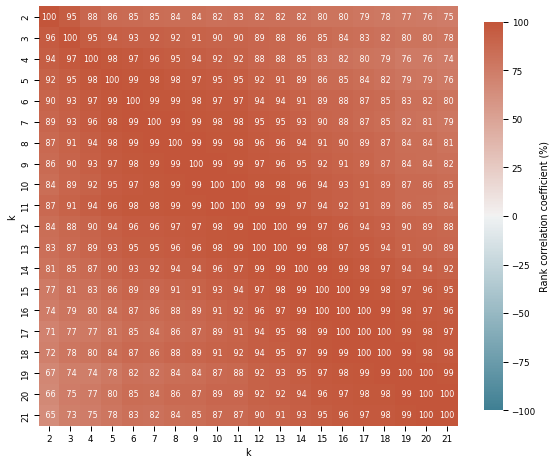

In [11]:
with sns.plotting_context('paper', font_scale=1):
    fig, axes = plt.subplots(1, figsize=(8, 8))
    ax = axes
    
    df = spearmans(vamps, 30)

    sns.heatmap(df*100, ax=ax, vmin=-100, vmax=100, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), cbar=True, 
                annot_kws=dict(size='small'), square=True, fmt='3.0f', 
                cbar_kws=dict(shrink=0.7, label='Rank correlation coefficient (%)'))
  
    ax.set_xlabel('k')
    ax.set_ylabel('k')

#     ax.set_title(f'VAMP2(k={proc})')
                
    plt.tight_layout()
    plt.savefig(f'{protein}/{protein}_vamp_rank_vs_n_proc.pdf', bbox_inches='tight')